# 心脏图像分割知识点
- nii文件是医学三维影像文件，nii格式图片主要包含三部分信息：hdr（包含固定信息数据：维度，体素大小，数据类型，转换矩阵）, ext（自行添加的信息）, img（图像）
- nii 格式是保存医学图像非常重要一种格式，核磁共振成像（MRI）或者CT图像通常会以这种格式保存
- 由于图像为3D，故还保存了一些额外信息，比如每个像素间的距离，原点坐标，方向等等，这样根据像素间的距离就可以计算某一像素在空间中真正的坐标了。
- SimpleITK 是专门处理医学影像的软件，SimpleITK 图像类是多维度的（2D~5D，包含成员：原点坐标，体素即三维像素距离，各切片图像尺寸，方向向量）
- SimpleITK图像顺序是x，y，z三个方向的大小；而numpy矩阵的顺序是z，y，x三个方向的大小, 要注意索引位置,**因为在训练时一般是[x, y, z]，所以我们在dataset中需要将图像的坐标轴转换一下，即做一个transpose(2, 1, 0)操作。**
- -------
```python
# 获取图像的大小，size为图像的每一个维度的长度，即每个维度像素点的个数
# 读取的顺序为[X, Y, Z], 即先宽度，后高度，再深度，对应的三维医学图像中为：先矢状位，后冠状位，再横断位。
print(image.GetSize()) 

# 获取图像的原点坐标，读取顺序同GetSize()方法
print(image.GetOrigin()) 

# 获取每个维度上像素或体素之间的间距，单位mm，其中对于二维图像是像素，三维图像是体素
# 读取顺序同GetSize()方法， 每个维度可以具有不同的间距，且每个维度不一定是正交的。
print(image.GetSpacing()) 

# 获取图像的方向，即图像坐标系相对世界坐标系的角度，角度采用的是方向余弦矩阵
print(image.GetDirection()) 
```

In [ ]:
import SimpleITK as sitk
import gzip
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# 解压
dir_path='./'
zipname="heart.nii.gz"
filename='heart.nii'

file=gzip.GzipFile(os.path.join(dir_path,zipname))
with open(os.path.join(dir_path,filename),'wb') as f:
    f.write(file.read())

# 读取图片
image_path=os.path.join(dir_path,filename)
image=sitk.ReadImage(image_path)

'''
保存图片
sitk.WriteImage(image,image_path) 
'''

# sitk image to numpy 
shape_img = image.GetSize() #输出形状为：(Width, Height,Depth,Channel)，即原始SimpleITK数据的存储形式
print("image size:", shape_img) # image size:(216,256,13,25)

# 将nii图片转换为numpy array
image_array = sitk.GetArrayFromImage(image)
# 将图片上的值标准化到0-255之间
cv2.normalize(image_array, image_array, 0, 255, cv2.NORM_MINMAX)
print("np_array size:", image_array.shape) # np_array size:(25,13,256,216)

'''
该数据集的一个nii文件有四个维度(25,13,256,216)分别对应（通道数，深度，长度，宽度）(t,z,y,x)
'''

In [ ]:
img_select = image_array[0,2,:,:]
plt.imshow(img_select)


# 数据来源
- 数据集来源于多中心，多供应商和多疾病心脏图像分割挑战赛。由375名肥厚性和扩张型心肌病患者以及健康受试者组成。使用四个不同供应商（西门子，通用电气，飞利浦和佳能）的磁共振扫描仪，分别在三个不同国家（西班牙，德国和加拿大）的临床中心对所有受试者进行了扫描。
- 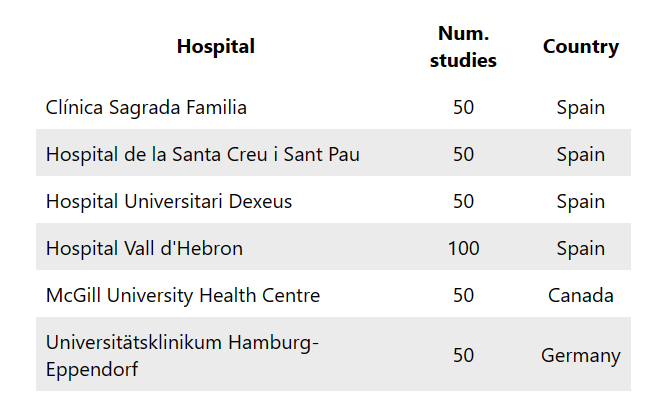
- 训练集包含来自两个不同MRI供应商的150个带标注的图像（每个75个），和来自第三供应商的25个未带标注的图像。由来自各个机构经验丰富的临床医生对CMR图像进行了分割，包括左（LV）和右心室（RV）血池以及左心室心肌（MYO）的轮廓。标签为：0（背景），1（LV），2（MYO）和3（RV）。
- 所用的MRI图像是心脏电影成像序列，是带时间维度的三维心脏图像。
- 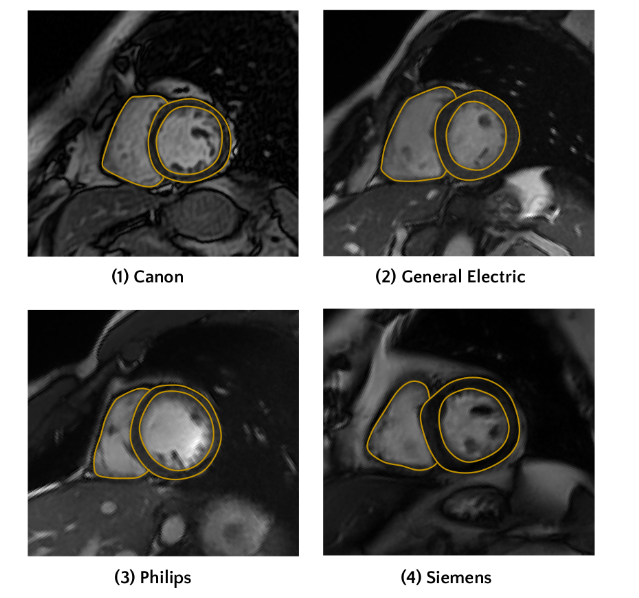

# 预处理：对医学图像降采样，增加层厚减少数据量
- 由于训练的显卡是1080ti的11G显存的，所以首先将训练原始图像和标注图像进行图像大小缩放到固定大小


In [ ]:
# flag = ResampleCMRImage(img, lab, tgt_path, patient_name, img_name, (1.2, 1.2))
# 将所有数据重新采样为 x-y 平面中 1.2x1.2 mm 的间距。我们不会更改z轴的间距，因为UTNet是一个2D网络。
# img 为原始图像，lab为带标签（即分割完）的图像
filename2="heart_gt.nii.gz"
lab=sitk.ReadImage(os.path.join(dir_path,filename2))
img=image
patient_name="heart"
image_name="heart"

print(img.GetSpacing(),lab.GetSpacing())
print(img.GetSize(),lab.GetSize())

spacing=img.GetSpacing()
origin=img.GetOrigin()
print(origin)

npimg=sitk.GetArrayFromImage(img)
nplab=sitk.GetArrayFromImage(lab)
t,z,y,x=npimg.shape # （通道数，深度，长度，宽度）
print(t,z,y,x)

# 全0表示没有标签（全黑）
for i in range(t):
    print(nplab[i].max(),end=' ')
    
plt.imshow(nplab[0,2,:,:])

In [ ]:
# 由上面结果可知，只采样img[0]和img[9]
tmp_img=sitk.GetImageFromArray(npimg[0])
tmp_lab=sitk.GetImageFromArray(nplab[0])
print(spacing[0:3])

tmp_img.SetSpacing(spacing[0:3])
tmp_img.SetOrigin(spacing[0:3])
tmp_lab.SetSpacing(spacing[0:3])
tmp_lab.SetOrigin(spacing[0:3])

# re_img = ResampleXYZAxis(tmp_img, space=(target_space[0]=1.2, target_space[1]=1.2, spacing[2]=z轴不变))
# re_lab = ResampleFullImageToRef(tmp_lab, re_img)

# 创建一个三维图像变换，并将其初始化为恒等变换
identity1 = sitk.Transform(3, sitk.sitkIdentity)
sp1 = tmp_img.GetSpacing() #  获取输入图像的原始空间分辨率
sz1 = tmp_img.GetSize()    #  获取输入图像的原始尺寸

# 根据新的空间分辨率计算的目标图像的新尺寸，以便进行重采样。
sz2 = (int(round(sz1[0] * sp1[0] * 1.0 / 1.2)), int(round(sz1[1] * sp1[1] * 1.0 / 1.2)),
           int(round(sz1[2] * sp1[2] * 1.0 / spacing[2])))

imRefImage = sitk.Image(sz2, tmp_img.GetPixelIDValue())
imRefImage.SetSpacing((1.2,1.2,spacing[2]))
imRefImage.SetOrigin(tmp_img.GetOrigin())
imRefImage.SetDirection(tmp_img.GetDirection())

# 使用 sitk.Resample 函数对输入图像 tmp_img 进行重采样，将其重采样为新的目标图像 imRefImage，使用恒等变换和线性插值。
re_img = sitk.Resample(tmp_img, imRefImage, identity1, sitk.sitkLinear)

'''
将 tmp_lab 按照参考图像 re_img 的空间特性进行重新采样，生成一个新的标签图像 re_lab,
使得它们在空间分辨率、尺寸、原点和方向上保持一致。
最近邻插值方法用于确保标签的像素值在重采样过程中保持不变，以避免引入不合理的变化 
'''
imRefImage = sitk.Image(re_img.GetSize(), tmp_lab.GetPixelIDValue())
imRefImage.SetSpacing(re_img.GetSpacing())
imRefImage.SetOrigin(re_img.GetOrigin())
imRefImage.SetDirection(re_img.GetDirection())

re_lab = sitk.Resample(tmp_lab, imRefImage, identity1, sitk.sitkNearestNeighbor)

sitk.WriteImage(re_img, '%s_processed.nii.gz' % (image_name))
sitk.WriteImage(re_lab, '%s_processed_gt.nii.gz' % (image_name))

                        

In [ ]:
npimg1=sitk.GetArrayFromImage(re_img)
nplab1=sitk.GetArrayFromImage(re_lab)
print(npimg1.shape)

fig, axes = plt.subplots(1, 4, figsize=(10, 4))  # 一行三列的网格

# 在每个子图中绘制图像
axes[0].imshow(img_select)
axes[0].set_title('Image 1')

axes[1].imshow(nplab[0,2,:,:])
axes[1].set_title('Image 2')

axes[2].imshow(npimg1[2])
axes[2].set_title('Image 3')

axes[3].imshow(nplab1[2])
axes[3].set_title('Image 4')

# 调整子图之间的间距
plt.tight_layout()

# 显示图像
plt.show()

In [ ]:
plt.imshow(img_select,alpha=0.7)
plt.imshow(nplab[0,2,:,:],alpha=0.3)
plt.show()


# 残差卷积网络

In [ ]:
import torch.nn as nn
'''
这是一个定义了一个基本的残差块(Residual Block)的 PyTorch 模块类 BasicBlock,用于神经网络的构建。
残差块是深度卷积神经网络中的重要组件之一,用于构建深层网络,并通过跳跃连接(shortcut connection)来解决梯度消失问题，以便更好地训练深层网络。
'''
class BasicBlock(nn.Module):

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        # 如果步长不为 1 或输入通道数不等于输出通道数，就会改变x尺寸以适应out尺寸
        if stride != 1 or inplanes != planes:
            self.shortcut = nn.Sequential(
                nn.BatchNorm2d(inplanes),
                self.relu,
                nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        residue = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out += self.shortcut(residue)

        return out
    
    ''' 
    BasicBlock(1,32) ,假设x为一张(256,256,1)的图片数据
    x-->bn1,relu,conv1-->(256,256,32)-->bn2,relu,conv2-->(256,256,32)-->+残差shortcut --> (256,256,32)
     
    '''


# 深度可分离卷积网络

In [ ]:
''' 
这个模块类实现了深度可分离卷积操作，可以用于构建卷积神经网络中的不同层级。深度可分离卷积可以有效减少计算量和参数数量，从而加速训练过程并减少过拟合
效果比1*1卷积好
'''
class depthwise_separable_conv(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, kernel_size=3, padding=1, bias=False):
        super().__init__()
        # 这一行创建了一个深度卷积层 depthwise，其中 groups=in_ch 表示将输入通道分成多个组，每个组之间进行独立的卷积操作。这实现了深度可分离卷积的深度卷积部分。
        self.depthwise = nn.Conv2d(in_ch, in_ch, kernel_size=kernel_size, padding=padding, groups=in_ch, bias=bias,
                                   stride=stride)
        # 这一行创建了一个逐点卷积层 pointwise，用于将深度卷积的输出进行逐点卷积，实现特征的融合和映射。
        self.pointwise = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)

        return out

# 输入相关的相对位置embedding

In [ ]:
''' 
这个模块实现了一种基于输入相关的相对位置嵌入，用于帮助自注意力模型捕捉输入数据中不同位置之间的关系。
B 是批次大小(batch size)。
Nh 是注意力头数。
HW 是输入的特征图的高度和宽度的乘积（通常表示空间尺寸）。
dim 是每个位置的特征维度。
'''
class RelativePositionEmbedding(nn.Module):
    def __init__(self, dim, shape):
        super().__init__()
        self.dim = dim
        self.shape = shape

        # 创建可学习的参数 key_rel_w 和 key_rel_h
        self.key_rel_w = nn.Parameter(torch.randn((2 * self.shape - 1, dim)) * 0.02) # (15,8)
        self.key_rel_h = nn.Parameter(torch.randn((2 * self.shape - 1, dim)) * 0.02) # (15,8)

        # 创建相对位置索引矩阵
        coords = torch.arange(self.shape)
        # coords[None,:]: tensor([[0, 1, 2, 3, 4, 5, 6, 7]]) ,coords[:,None]: tensor([[0],[1],[2],[3],[4],[5],[6],[7]])
        relative_coords = coords[None, :] - coords[:, None]
        relative_coords += self.shape - 1
        
        ''' 
        relative_coords: tensor([[ 7,  8,  9, 10, 11, 12, 13, 14],
        [ 6,  7,  8,  9, 10, 11, 12, 13],
        [ 5,  6,  7,  8,  9, 10, 11, 12],
        [ 4,  5,  6,  7,  8,  9, 10, 11],
        [ 3,  4,  5,  6,  7,  8,  9, 10],
        [ 2,  3,  4,  5,  6,  7,  8,  9],
        [ 1,  2,  3,  4,  5,  6,  7,  8],
        [ 0,  1,  2,  3,  4,  5,  6,  7]])
        '''

        self.register_buffer('relative_position_index', relative_coords)

    def forward(self, q, Nh, H, W, dim_head):
        B, _, _, dim = q.shape

        # 将输入重排为 B, Nh, H, W, dim_head
        q = rearrange(q, 'b heads (h w) dim_head -> b heads h w dim_head', b=B, dim_head=dim_head, heads=Nh, h=H, w=W)

        # 计算相对位置注意力
        rel_logits_w = self.relative_logits_1d(q, self.key_rel_w, 'w') # [2, 4, 1024, 64]
        rel_logits_h = self.relative_logits_1d(q.permute(0, 1, 3, 2, 4), self.key_rel_h, 'h') # [2, 4, 1024, 64] ,permute 转置

        return rel_logits_w, rel_logits_h

    def relative_logits_1d(self, q, rel_k, case):
        B, Nh, H, W, dim = q.shape

        '''
        这行代码使用了 torch.einsum 函数来进行张量操作，用于计算相对位置注意力权重。
        'bhxyd,md->bhxym' 是一个字符串，它描述了两个输入张量 q 和 rel_k 之间的操作。这里使用了一种简化的爱因斯坦求和约定表示法来指定操作。
        bhxyd: 这是 q 张量的索引标签。其中,b 代表批次(batch),h 代表注意力头数,x 和 y 代表空间维度, d 代表q的特征维度。
        md:这是 rel_k 张量的索引标签。其中,m 代表 rel_k 的特征维度,d 是 q 的特征维度。
        bhxym: 这是输出张量的索引标签。它与 q 张量的索引标签相似，但最后一个维度变成 m,表示位置向量的特征维度。 
        '''
        rel_logits = torch.einsum('bhxyd,md->bhxym', q, rel_k) # [2, 4, 32,32, 15]

        if W != self.shape:
            # 输入二维张量，指定dim=0，重复次数为 W // self.shape次，表示把输入张量每行元素重复 W // self.shape次
            relative_index = torch.repeat_interleave(self.relative_position_index, W // self.shape, dim=0) # [32，8]
             
        else:
            relative_index = self.relative_position_index.view(1, 1, 1, W, self.shape) # [1,1,1,32,32]

        relative_index = relative_index.repeat(B, Nh, H, 1, 1) # [2,4,32,32,8]

        # 从完整数据中按索引取值,从第4维按索引取值
        rel_logits = torch.gather(rel_logits, 4, relative_index) # [2,4,32,32,8]
        rel_logits = rel_logits.unsqueeze(3) # [2, 4, 32, 1, 32, 8]
        rel_logits = rel_logits.repeat(1, 1, 1, self.shape, 1, 1) # [2, 4, 32, 8, 32, 8]
        

        if case == 'w':
            rel_logits = rearrange(rel_logits, 'b heads H h W w -> b heads (H W) (h w)')
        elif case == 'h':
            rel_logits = rearrange(rel_logits, 'b heads W w H h -> b heads (H W) (h w)')

        return rel_logits

import torch
import torch.nn as nn
from einops import rearrange

# 创建一个输入张量
B, Nh, H, W, dim_head = 2, 4, 32, 32, 8
q = torch.randn(B, Nh, H * W, dim_head)
print("input:",q.shape)

# 初始化 RelativePositionEmbedding 模块
shape = 8
dim = dim_head
relative_position_embedding = RelativePositionEmbedding(dim, shape)

# 计算相对位置注意力
rel_logits_w, rel_logits_h = relative_position_embedding(q, Nh, H, W, dim_head)

print("Relative Position Attention (Width):")
print(rel_logits_w.shape)

print("\nRelative Position Attention (Height):")
print(rel_logits_h.shape)


# 输入无关的相对位置编码

In [ ]:
''' 
这个模型是一个用于计算输入矩阵各元素之间的相对位置偏置的神经网络模块。它被设计用于自注意力机制中，特别是在多头注意力的上下文中。
实现了基于输入无关的相对位置注意力（Relative Position Attention）
这个模型的设计借鉴了Swin Transformer模型，并提供了一种输入无关的相对位置信息。
'''

class RelativePositionBias(nn.Module):
    # input-independent relative position attention
    def __init__(self, num_heads, h, w):
        super().__init__()
        self.num_heads = num_heads
        self.h = h
        self.w = w

        # 创建相对位置偏置参数
        self.relative_position_bias_table = nn.Parameter(torch.randn((2 * h - 1) * (2 * w - 1), num_heads) * 0.02)  # (961,4)

        # 创建相对位置索引
        coords_h = torch.arange(self.h) # [16]
        coords_w = torch.arange(self.w)
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, h, w (2,16,16)
        coords_flatten = torch.flatten(coords, 1)  # 2, hw (2,256)

        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += self.h - 1
        relative_coords[:, :, 1] += self.w - 1
        relative_coords[:, :, 0] *= 2 * self.h - 1  # (256,256,2)
        relative_position_index = relative_coords.sum(-1)  # hw, hw (256,256)

        self.register_buffer("relative_position_index", relative_position_index)

    def forward(self, H, W):
        '''
        print(self.relative_position_index.view(-1).shape) --> [65536]
        self.relative_position_bias_table[self.relative_position_index.view(-1)] --> (65536,4)
        print(relative_position_bias.shape) --> torch.Size([16, 16, 256, 4])
        print(relative_position_bias_expand_h.shape) --> torch.Size([16, 16, 256, 4])
        print(relative_position_bias_expanded.shape) --> torch.Size([16, 16, 256, 4])
        print(relative_position_bias_expanded.shape) --> torch.Size([1, 4, 256, 256])
        '''
        # 计算相对位置偏置
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(self.h,self.w,self.h * self.w,-1)  # h, w, hw, nH   
        
        relative_position_bias_expand_h = torch.repeat_interleave(relative_position_bias, H // self.h, dim=0)

        relative_position_bias_expanded = torch.repeat_interleave(relative_position_bias_expand_h, W // self.w, dim=1)  # HW, hw, nH     
                                                              
        relative_position_bias_expanded = relative_position_bias_expanded.view(H * W, self.h * self.w,self.num_heads).permute(2, 0,1).contiguous().unsqueeze(0)
    
        return relative_position_bias_expanded

# 创建相对位置偏置模型实例
num_heads = 4
h = 16 # 高的位置向量维度
w = 16 # 宽的位置向量维度
relative_position_bias_model = RelativePositionBias(num_heads, h, w)

# 输入图片尺寸为（16，16），H=W=16
H = W = 16

# 计算相对位置偏置
relative_position_bias = relative_position_bias_model(H, W)

# 打印相对位置偏置的形状
print("Relative Position Bias Shape:", relative_position_bias.shape)


# 线性多头注意力编码器
- 2D 输入无关的相对位置编码比 1D 输入相关的相对位置编码稍微更好一些**原因**:
  - *2D 输入无关的相对位置编码(Input-Independent)* 在这种方法中，相对位置编码是事先计算好的，**不依赖于输入数据的内容**。
    例如，在图像处理中，可以根据图像的尺寸和像素坐标来生成相对位置编码。
    这样的编码对于不同的输入数据是固定的，因此在模型训练和推理过程中可以**共享**，**减少了模型的参数数量**。这有助于模型更好地泛化到不同的输入。
  - *1D 输入相关的相对位置编码(Input-Dependent)*: 在这种方法中，相对位置编码是根据输入数据动态生成的，它可能会**受到输入数据的内容和特性的影响**。这意味着每个输入数据都会生成不同的相对位置编码，**增加了模型的参数数量**，并可能导致**过拟合**问题。
    此外，由于相对位置编码与输入数据有关，模型可能需要更多的数据来学习和泛化这些编码。
  - 使用2D输入无关的相对位置编码通常更有优势,因为它可以在不增加参数数量的情况下为模型提供有关输入数据之间关系的信息，而且更具**通用性**

In [ ]:
''' 
nn.Dropout 是 PyTorch 中用于实现 dropout 操作的类。
Dropout 是一种用于防止神经网络过拟合的正则化技术，它在训练过程中随机丢弃一些神经元的输出，以减少神经元之间的依赖性，从而提高模型的泛化能力。
以下模型实现了实现了一个线性注意力编码层。该层接受一个输入特征图 x,并在输入的基础上应用线性注意力机制
dim:输入特征图 x 的通道数。
heads:注意力头的数量。
dim_head:每个注意力头的维度。
attn_drop:注意力系数的 dropout 概率。
proj_drop:投影层的 dropout 概率。
reduce_size:降低分辨率的大小。
projection:降低分辨率的投影方法。
rel_pos:是否使用相对位置编码。
'''
class LinearAttention(nn.Module):

    def __init__(self, dim, heads=4, dim_head=64, attn_drop=0., proj_drop=0., reduce_size=16, projection='interp',
                 rel_pos=True):
        super().__init__()

        self.inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** (-0.5)
        self.dim_head = dim_head
        self.reduce_size = reduce_size
        self.projection = projection
        self.rel_pos = rel_pos

        # 深度可分离卷积比1*1卷积效果好
        # self.to_qkv = nn.Conv2d(dim, self.inner_dim*3, kernel_size=1, stride=1, padding=0, bias=True)
        # self.to_out = nn.Conv2d(self.inner_dim, dim, kernel_size=1, stride=1, padding=0, bias=True)

        self.to_qkv = depthwise_separable_conv(dim, self.inner_dim * 3) # 输入特征图 x 经过深度可分离卷积得到查询（q）、键（k）和值（v）。
        self.to_out = depthwise_separable_conv(self.inner_dim, dim) # 经过注意力后的输出经过深度可分离卷积

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj_drop = nn.Dropout(proj_drop)

        if self.rel_pos:
            # 2D 输入无关的相对位置编码比 1D 输入相关的相对位置编码稍微更好一些
            self.relative_position_encoding = RelativePositionBias(heads, reduce_size, reduce_size)
            # self.relative_position_encoding = RelativePositionEmbedding(dim_head, reduce_size)

    def forward(self, x):

        B, C, H, W = x.shape

        # B, inner_dim, H, W
        qkv = self.to_qkv(x) # 将输入特征图 x 经过深度可分离卷积得到查询（q）、键（k）和值（v） 
        q, k, v = qkv.chunk(3, dim=1) # 将张量 qkv 按照维度 dim=1 进行分割，分成三个块，分别对应查询（q）、键（k）、值（v）。

        # 根据设定的投影方式，对键（k）和值（v）进行投影。
        ''' 
        inerp
        k 和 v:要进行插值的输入张量。
        size=self.reduce_size:目标尺寸，即要将张量调整到的大小。
        mode='bilinear'：插值模式，这里使用双线性插值。双线性插值是一种常用的插值方法，它可以平滑地对像素进行重新采样。
        align_corners=True: 用于控制插值是否对角点进行对齐。在图像处理中，通常设置为 True。
        这行代码的目的是将键k和值v的尺寸调整为指定的 self.reduce_size,以便在接下来的计算中使用。
        插值操作可以使得低分辨率的特征图在进行注意力计算时具有更大的感受野，从而提升模型的性能。 
        
        maxpool
        将键k和值v的尺寸调整为指定的 self.reduce_size,以便在接下来的计算中使用。
        自适应最大池化操作可以在保持重要信息的同时减少特征图的尺寸，从而降低计算负担并提高计算效率。
        '''
        if self.projection == 'interp' and H != self.reduce_size:
            k, v = map(lambda t: F.interpolate(t, size=self.reduce_size, mode='bilinear', align_corners=True), (k, v))

        elif self.projection == 'maxpool' and H != self.reduce_size:
            k, v = map(lambda t: F.adaptive_max_pool2d(t, output_size=self.reduce_size), (k, v))

        q = rearrange(q, 'b (dim_head heads) h w -> b heads (h w) dim_head', dim_head=self.dim_head, heads=self.heads,h=H, w=W)
        k, v = map(lambda t: rearrange(t, 'b (dim_head heads) h w -> b heads (h w) dim_head', dim_head=self.dim_head,
                                       heads=self.heads, h=self.reduce_size, w=self.reduce_size), (k, v))

        # 计算查询（q）与键（k）之间的注意力得分。
        q_k_attn = torch.einsum('bhid,bhjd->bhij', q, k) 

        # 如果启用了相对位置编码，将相对位置编码应用于注意力得分。
        if self.rel_pos:
            relative_position_bias = self.relative_position_encoding(H, W)
            q_k_attn += relative_position_bias  
            # rel_attn_h, rel_attn_w = self.relative_position_encoding(q, self.heads, H, W, self.dim_head)
            # q_k_attn = q_k_attn + rel_attn_h + rel_attn_w

        # 对注意力得分进行缩放并应用 dropout。
        q_k_attn *= self.scale 
        q_k_attn = F.softmax(q_k_attn, dim=-1)
        q_k_attn = self.attn_drop(q_k_attn)

        # # 对输出特征进行投影并应用 dropout。
        out = torch.einsum('bhij,bhjd->bhid', q_k_attn, v) 
        out = rearrange(out, 'b heads (h w) dim_head -> b (dim_head heads) h w', h=H, w=W, dim_head=self.dim_head,
                        heads=self.heads)

        out = self.to_out(out)
        out = self.proj_drop(out)

        return out, q_k_attn
    
    # 定义输入特征图 x
x = torch.randn(1, 64, 32, 32)  # B, C, H, W

# 创建 LinearAttention 模型实例
attention_layer = LinearAttention(dim=64, heads=4, dim_head=16, attn_drop=0.1, proj_drop=0.2,
                                  reduce_size=16, projection='interp', rel_pos=True)

# 进行前向传播
output, attention = attention_layer(x)

# 输出结果的形状
print("Output Shape:", output.shape)
print("Attention Shape:", attention.shape)

# 基本转换块（各种网络的组合）*编码部分*

In [ ]:
''' 
这个模型类实际上是一个转换块的抽象，
将输入特征图通过自注意力机制进行处理，然后添加了残差连接和线性映射，最终输出转换后的特征。

in_ch:输入特征图的通道数。
heads:自注意力头的数量。
dim_head:每个自注意力头的特征维度。
attn_drop:自注意力矩阵的 dropout 概率。
proj_drop:投影层的 dropout 概率。
reduce_size:可选的降维大小，用于投影或池化。
projection:用于指定投影方式，可以是 'interp'（插值）或 'maxpool'（最大池化）。
rel_pos:是否使用相对位置编码。

'''
class BasicTransBlock(nn.Module):

    def __init__(self, in_ch, heads, dim_head, attn_drop=0., proj_drop=0., reduce_size=16, projection='interp',
                 rel_pos=True):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_ch)

        self.attn = LinearAttention(in_ch, heads=heads, dim_head=in_ch // heads, attn_drop=attn_drop,
                                    proj_drop=proj_drop, reduce_size=reduce_size, projection=projection,
                                    rel_pos=rel_pos)

        self.bn2 = nn.BatchNorm2d(in_ch)
        self.relu = nn.ReLU(inplace=True)
        self.mlp = nn.Conv2d(in_ch, in_ch, kernel_size=1, bias=False)
        # conv1x1 has not difference with mlp in performance

    def forward(self, x):
        # 将输入数据 x 通过第一个 Batch Normalization 层。
        out = self.bn1(x)
        
        # 将输入数据传递给自注意力模块，得到自注意力的输出 out 和注意力矩阵 q_k_attn。
        out, q_k_attn = self.attn(out)

        # 对自注意力输出和输入进行残差连接，并将结果保存在 residue 中。
        out = out + x
        residue = out

        # 将 out 通过第二个 Batch Normalization 层。
        out = self.bn2(out)
        
        # 将 out 通过 ReLU 激活函数。
        out = self.relu(out)
        
        # 将 out 通过 1x1 卷积层（MLP）。
        out = self.mlp(out)

        # 将 residue 加到最终输出 out 上。
        out += residue

        return out

in_channels = 64
input_size = (128, 128)

# 创建 BasicTransBlock 模块
trans_block = BasicTransBlock(in_ch=in_channels, heads=4, dim_head=16, attn_drop=0.1, proj_drop=0.2)

# 生成随机输入特征图
input_data = torch.randn(1, in_channels, *input_size)
print("Input size: ",input_data.shape)

# 通过 BasicTransBlock 进行前向传播
output = trans_block(input_data)

# 输出转换后的特征图大小
print("Output size:", output.shape)

# 下采样转换块（图中下箭头以及指向层）
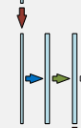

In [ ]:
'''
它接受输入特征图x,并将其通过一系列的层来进行处理和下采样。
具体来说,这个模块的主要功能是构建一个包含多个基本块(BasicBlock或BottleneckBlock)
和注意力块(BasicTransBlock)的堆叠。

in_ch: 输入特征图的通道数。
out_ch: 输出特征图的通道数。
num_block: 要堆叠的基本块和注意力块的数量。
bottleneck: 一个布尔值,表示是否使用瓶颈块(BottleneckBlock),默认为False。
maxpool: 一个布尔值,表示是否使用最大池化层,默认为True。
heads: 多头自注意力的头数,默认为4。
dim_head: 每个注意力头的维度,默认为64。
attn_drop: 注意力机制中的注意力丢弃率,默认为0。
proj_drop: 投影层的丢弃率,默认为0。
reduce_size: 降维后的特征图大小,默认为16。
projection: 降维时使用的投影方式，可选'interp'（插值）或'maxpool'（最大池化），默认为'interp'。
rel_pos: 是否使用相对位置编码,默认为True。
'''
class down_block_trans(nn.Module):
    def __init__(self, in_ch, out_ch, num_block, bottleneck=False, maxpool=True, heads=4, dim_head=64, attn_drop=0.,
                 proj_drop=0., reduce_size=16, projection='interp', rel_pos=True):

        super().__init__()

        block_list = []

        if bottleneck:
            block = BottleneckBlock
        else:
            block = BasicBlock

        attn_block = BasicTransBlock

        if maxpool:
            block_list.append(nn.MaxPool2d(2))
            block_list.append(block(in_ch, out_ch, stride=1))
        else:
            block_list.append(block(in_ch, out_ch, stride=2))

        assert num_block > 0
        for i in range(num_block):
            block_list.append(
                attn_block(out_ch, heads, dim_head, attn_drop=attn_drop, proj_drop=proj_drop, reduce_size=reduce_size,
                           projection=projection, rel_pos=rel_pos))
        self.blocks = nn.Sequential(*block_list)

    def forward(self, x):

        out = self.blocks(x)

        return out

# 线性多头注意力解码器(cross-attention)

In [ ]:
'''
它实现了一个线性注意力解码器。
这个解码器接受两个输入：一个低分辨率的特征图 x 和一个高分辨率的特征图 q,然后在输入的基础上应用线性注意力机制进行解码。

in_dim: 输入特征图 x 的通道数。
out_dim: 输出特征图的通道数。
heads: 注意力头的数量。
dim_head: 每个注意力头的维度。
attn_drop: 注意力系数的 dropout 概率。
proj_drop: 投影层的 dropout 概率。
reduce_size: 降低分辨率的大小。
projection: 降低分辨率的投影方法。
rel_pos: 是否使用相对位置编码。
'''
class LinearAttentionDecoder(nn.Module):

    def __init__(self, in_dim, out_dim, heads=4, dim_head=64, attn_drop=0., proj_drop=0., reduce_size=16,
                 projection='interp', rel_pos=True):
        super().__init__()

        self.inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** (-0.5)
        self.dim_head = dim_head
        self.reduce_size = reduce_size
        self.projection = projection
        self.rel_pos = rel_pos

        # depthwise conv is slightly better than conv1x1
        # self.to_kv = nn.Conv2d(dim, self.inner_dim*2, kernel_size=1, stride=1, padding=0, bias=True)
        # self.to_q = nn.Conv2d(dim, self.inner_dim, kernel_size=1, stride=1, padding=0, bias=True)
        # self.to_out = nn.Conv2d(self.inner_dim, dim, kernel_size=1, stride=1, padding=0, bias=True)

        self.to_kv = depthwise_separable_conv(in_dim, self.inner_dim * 2)
        self.to_q = depthwise_separable_conv(out_dim, self.inner_dim)
        self.to_out = depthwise_separable_conv(self.inner_dim, out_dim)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj_drop = nn.Dropout(proj_drop)

        if self.rel_pos:
            self.relative_position_encoding = RelativePositionBias(heads, reduce_size, reduce_size)
            # self.relative_position_encoding = RelativePositionEmbedding(dim_head, reduce_size)

    def forward(self, q, x):

        B, C, H, W = x.shape  # low-res feature shape
        BH, CH, HH, WH = q.shape  # high-res feature shape

        k, v = self.to_kv(x).chunk(2, dim=1)  # B, inner_dim, H, W
        q = self.to_q(q)  # BH, inner_dim, HH, WH

        # 使用键值投影层将输入特征图投影为键（k）和值（v）。
        if self.projection == 'interp' and H != self.reduce_size:
            k, v = map(lambda t: F.interpolate(t, size=self.reduce_size, mode='bilinear', align_corners=True), (k, v))

        elif self.projection == 'maxpool' and H != self.reduce_size:
            k, v = map(lambda t: F.adaptive_max_pool2d(t, output_size=self.reduce_size), (k, v))

        # 对查询（q）进行重排以适应多头自注意力计算的形状，并对键（k）和值（v）进行重排以适应相对位置编码的形状。
        q = rearrange(q, 'b (dim_head heads) h w -> b heads (h w) dim_head', dim_head=self.dim_head, heads=self.heads,
                      h=HH, w=WH)
        k, v = map(lambda t: rearrange(t, 'b (dim_head heads) h w -> b heads (h w) dim_head', dim_head=self.dim_head,
                                       heads=self.heads, h=self.reduce_size, w=self.reduce_size), (k, v))

        # 使用torch.einsum计算查询-键（q-k）注意力权重矩阵。
        q_k_attn = torch.einsum('bhid,bhjd->bhij', q, k)

        # 如果启用相对位置编码，将相对位置偏置加到注意力权重矩阵中。
        if self.rel_pos:
            relative_position_bias = self.relative_position_encoding(HH, WH)
            q_k_attn += relative_position_bias
            # rel_attn_h, rel_attn_w = self.relative_position_encoding(q, self.heads, HH, WH, self.dim_head)
            # q_k_attn = q_k_attn + rel_attn_h + rel_attn_w

        # 对注意力权重进行缩放,将缩放后的注意力权重进行softmax操作，然后应用注意力丢弃（attn_drop）
        q_k_attn *= self.scale
        q_k_attn = F.softmax(q_k_attn, dim=-1)
        q_k_attn = self.attn_drop(q_k_attn)

        # 使用torch.einsum将注意力权重和值（v）进行加权求和，计算出上下文向量。
        out = torch.einsum('bhij,bhjd->bhid', q_k_attn, v)
        
        # 将上下文向量重新排列以适应输出的形状，并应用输出投影层，将其投影到指定的输出特征维度。
        out = rearrange(out, 'b heads (h w) dim_head -> b (dim_head heads) h w', h=HH, w=WH, dim_head=self.dim_head,
                        heads=self.heads)
        out = self.to_out(out)
        
        # 最后，对输出应用投影丢弃（proj_drop）
        out = self.proj_drop(out)

        return out, q_k_attn

# 创建一个LinearAttentionDecoder实例
in_dim = 64
out_dim = 32
heads = 4
dim_head = 8
attn_drop = 0.1
proj_drop = 0.1
reduce_size = 16
projection = 'interp'
rel_pos = True

decoder = LinearAttentionDecoder(in_dim, out_dim, heads, dim_head, attn_drop, proj_drop, reduce_size, projection, rel_pos)

# 生成输入数据（查询特征图和输入特征图）
B, C, HH, WH = 4, 64, 16, 16
BH, CH, H, W = 4, 32, 8, 8
q = torch.randn(BH, CH, HH, WH)
x = torch.randn(B, C, H, W)

# 使用LinearAttentionDecoder进行前向传播
out, q_k_attn = decoder(q, x)

# 输出的out表示经过注意力计算和投影的特征图
# q_k_attn表示计算得到的注意力权重矩阵
print("OUT: ",out.shape)
print("q_k_attn",q_k_attn.shape)

# 基于线性注意力解码器的解码器模块

In [ ]:
'''
in_ch: 输入通道数（特征图的通道数）。
out_ch: 输出通道数（解码后的特征图的通道数）。
heads: 注意力头的数量。
dim_head: 每个注意力头的维度。
attn_drop: 注意力矩阵的dropout概率。
proj_drop: 投影层的dropout概率。
reduce_size: 降低尺寸的大小。
projection: 降低尺寸时使用的投影方法（'interp'或'maxpool'）。
rel_pos: 是否使用相对位置编码。
'''
class BasicTransDecoderBlock(nn.Module):

    def __init__(self, in_ch, out_ch, heads, dim_head, attn_drop=0., proj_drop=0., reduce_size=16, projection='interp',
                 rel_pos=True):
        super().__init__()

        self.bn_l = nn.BatchNorm2d(in_ch)
        self.bn_h = nn.BatchNorm2d(out_ch)

        self.conv_ch = nn.Conv2d(in_ch, out_ch, kernel_size=1)
        self.attn = LinearAttentionDecoder(in_ch, out_ch, heads=heads, dim_head=out_ch // heads, attn_drop=attn_drop,
                                           proj_drop=proj_drop, reduce_size=reduce_size, projection=projection,
                                           rel_pos=rel_pos)

        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.mlp = nn.Conv2d(out_ch, out_ch, kernel_size=1, bias=False)

    def forward(self, x1, x2):
        # 使用self.conv_ch对低分辨率特征图x1进行卷积，然后使用插值（F.interpolate）将其大小调整为高分辨率特征图x2的大小，得到residue。
        residue = F.interpolate(self.conv_ch(x1), size=x2.shape[-2:], mode='bilinear', align_corners=True)
        
        # x1: low-res, x2: high-res,对输入的低分辨率特征图x1和高分辨率特征图x2分别进行批量归一化。
        x1 = self.bn_l(x1)
        x2 = self.bn_h(x2)

        # 使用self.attn模块对高分辨率特征图x2和低分辨率特征图x1进行解码，得到解码后的特征图out和注意力权重q_k_attn。
        out, q_k_attn = self.attn(x2, x1)

        # 将out和residue相加，得到out。(残差)
        out = out + residue
        residue = out

        # 对解码后的特征图out进行批量归一化。使用ReLU激活函数对out进行激活。使用self.mlp对out进行卷积操作，得到最终的解码结果。
        out = self.bn2(out)
        out = self.relu(out)
        out = self.mlp(out)

        out += residue

        return out

# 创建一个BasicTransDecoderBlock实例
in_ch = 256
out_ch = 128
heads = 4
dim_head = 32
attn_drop = 0.1
proj_drop = 0.1
reduce_size = 16
projection = 'interp'
rel_pos = True

decoder_block = BasicTransDecoderBlock(in_ch, out_ch, heads, dim_head, attn_drop, proj_drop, reduce_size, projection, rel_pos)

# 生成输入数据（低分辨率特征图x1和高分辨率特征图x2）
B, C, H, W = 4, in_ch, 32, 32
x1 = torch.randn(B, C, H, W)
x2 = torch.randn(B, out_ch, H * 2, W * 2)

# 使用BasicTransDecoderBlock进行前向传播
out = decoder_block(x1, x2)

print("x1:",x1.shape)
print("x2:",x2.shape)
print("out:",out.shape)

# 上采样转换块
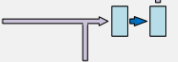
----
*这个模块的作用是在解码过程中引入注意力机制，并通过上采样将低分辨率特征融合到高分辨率特征中，从而产生更具表现力的解码结果。*

In [ ]:
'''
用于上采样和解码的模块，其主要功能是将低分辨率特征图上采样到高分辨率并进行解码。
in_ch: 输入通道数（低分辨率特征图的通道数）。
out_ch: 输出通道数（上采样后的高分辨率特征图的通道数）。
num_block: 要堆叠的解码块的数量。
bottleneck: 是否使用瓶颈块(BottleneckBlock),默认为False。
heads: 注意力头的数量。
dim_head: 每个注意力头的维度。
attn_drop: 注意力矩阵的dropout概率。
proj_drop: 投影层的dropout概率。
reduce_size: 降低尺寸的大小。
projection: 降低尺寸时使用的投影方法（'interp'或'maxpool'）。
rel_pos: 是否使用相对位置编码。
'''
class up_block_trans(nn.Module):
    def __init__(self, in_ch, out_ch, num_block, bottleneck=False, heads=4, dim_head=64, attn_drop=0., proj_drop=0.,
                 reduce_size=16, projection='interp', rel_pos=True):
        super().__init__()

        self.attn_decoder = BasicTransDecoderBlock(in_ch, out_ch, heads=heads, dim_head=dim_head, attn_drop=attn_drop,
                                                   proj_drop=proj_drop, reduce_size=reduce_size, projection=projection,
                                                   rel_pos=rel_pos)

        if bottleneck:
            block = BasicBlock
        else:
            block = BasicBlock
        attn_block = BasicTransBlock

        block_list = []

        for i in range(num_block):
            block_list.append(
                attn_block(out_ch, heads, dim_head, attn_drop=attn_drop, proj_drop=proj_drop, reduce_size=reduce_size,
                           projection=projection, rel_pos=rel_pos))

        block_list.append(block(2 * out_ch, out_ch, stride=1))

        self.blocks = nn.Sequential(*block_list)

    def forward(self, x1, x2):
        # x1: low-res feature, x2: high-res feature
        # 使用self.attn_decoder对输入的低分辨率特征图x1和高分辨率特征图x2进行解码和上采样，得到解码后的特征图out。
        out = self.attn_decoder(x1, x2)
        
        # 将解码后的特征图out和高分辨率特征图x2在通道维度上拼接起来，形成一个更丰富的特征图。
        out = torch.cat([out, x2], dim=1)
        
        # 使用一系列attn_block模块对拼接后的特征图进行注意力计算和解码。(残差模块)
        out = self.blocks(out)

        return out
    
# 创建一个up_block_trans实例
in_ch = 128
out_ch = 64
num_block = 0
heads = 4
dim_head = 32
attn_drop = 0.1
proj_drop = 0.1
reduce_size = 16
projection = 'interp'
rel_pos = True

up_block = up_block_trans(in_ch, out_ch, num_block, bottleneck=True, heads=heads, dim_head=dim_head, attn_drop=attn_drop,
                          proj_drop=proj_drop, reduce_size=reduce_size, projection=projection, rel_pos=rel_pos)

# 生成输入数据（低分辨率特征图x1和高分辨率特征图x2）
B, C, H, W = 4, in_ch, 16, 16
x1 = torch.randn(B, C, H, W)
x2 = torch.randn(B, out_ch, H * 2, W * 2)

# 使用up_block_trans进行前向传播
out = up_block(x1, x2)

print("x1:",x1.shape)
print("x2:",x2.shape)
print("out:",out.shape)

# UTNet
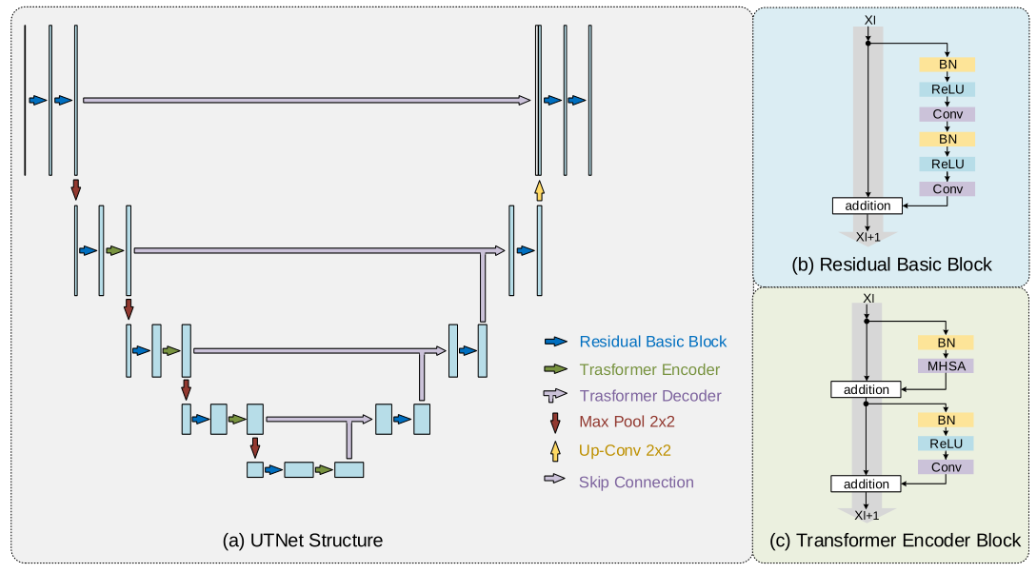

In [ ]:
''' 
UTNet 是一个基于注意力机制的卷积神经网络，用于进行图像分割任务。
in_chan: 输入图像的通道数。
base_chan: 基础通道数，控制模型的通道数。
num_classes: 输出类别的数量。
reduce_size: 用于降低分辨率的大小。
block_list: 一个字符串，指定哪些模块会被使用。
num_blocks: 每个分辨率下的块数量。
projection: 用于投影的方法，可以是 'interp' 或 'maxpool'。
num_heads: 每个分辨率下的注意力头数。
attn_drop: 注意力层的 Dropout 概率。
proj_drop: 投影层的 Dropout 概率。
bottleneck: 是否使用 Bottleneck 模块。
maxpool: 是否使用最大池化层。
rel_pos: 是否使用相对位置编码。
aux_loss: 是否使用辅助损失(Auxiliary Loss)。
'''
class UTNet(nn.Module):

    def __init__(self, in_chan, base_chan, num_classes=1, reduce_size=8, block_list='234', num_blocks=[1, 2, 4],
                 projection='interp', num_heads=[2, 4, 8], attn_drop=0., proj_drop=0., bottleneck=False, maxpool=True,
                 rel_pos=True, aux_loss=False):
        super().__init__()

        self.aux_loss = aux_loss
        self.inc = [BasicBlock(in_chan, base_chan)]
        if '0' in block_list:
            self.inc.append(BasicTransBlock(base_chan, heads=num_heads[-5], dim_head=base_chan // num_heads[-5],
                                            attn_drop=attn_drop, proj_drop=proj_drop, reduce_size=reduce_size,
                                            projection=projection, rel_pos=rel_pos))
            self.up4 = up_block_trans(2 * base_chan, base_chan, num_block=0, bottleneck=bottleneck, heads=num_heads[-4],
                                      dim_head=base_chan // num_heads[-4], attn_drop=attn_drop, proj_drop=proj_drop,
                                      reduce_size=reduce_size, projection=projection, rel_pos=rel_pos)

        else:
            self.inc.append(BasicBlock(base_chan, base_chan))
            self.up4 = up_block(2 * base_chan, base_chan, scale=(2, 2), num_block=2)
        self.inc = nn.Sequential(*self.inc)

        if '1' in block_list:
            self.down1 = down_block_trans(base_chan, 2 * base_chan, num_block=num_blocks[-4], bottleneck=bottleneck,
                                          maxpool=maxpool, heads=num_heads[-4], dim_head=2 * base_chan // num_heads[-4],
                                          attn_drop=attn_drop, proj_drop=proj_drop, reduce_size=reduce_size,
                                          projection=projection, rel_pos=rel_pos)
            self.up3 = up_block_trans(4 * base_chan, 2 * base_chan, num_block=0, bottleneck=bottleneck,
                                      heads=num_heads[-3], dim_head=2 * base_chan // num_heads[-3], attn_drop=attn_drop,
                                      proj_drop=proj_drop, reduce_size=reduce_size, projection=projection,
                                      rel_pos=rel_pos)
        else:
            self.down1 = down_block(base_chan, 2 * base_chan, (2, 2), num_block=2)
            self.up3 = up_block(4 * base_chan, 2 * base_chan, scale=(2, 2), num_block=2)

        if '2' in block_list:
            self.down2 = down_block_trans(2 * base_chan, 4 * base_chan, num_block=num_blocks[-3], bottleneck=bottleneck,
                                          maxpool=maxpool, heads=num_heads[-3], dim_head=4 * base_chan // num_heads[-3],
                                          attn_drop=attn_drop, proj_drop=proj_drop, reduce_size=reduce_size,
                                          projection=projection, rel_pos=rel_pos)
            self.up2 = up_block_trans(8 * base_chan, 4 * base_chan, num_block=0, bottleneck=bottleneck,
                                      heads=num_heads[-2], dim_head=4 * base_chan // num_heads[-2], attn_drop=attn_drop,
                                      proj_drop=proj_drop, reduce_size=reduce_size, projection=projection,
                                      rel_pos=rel_pos)

        else:
            self.down2 = down_block(2 * base_chan, 4 * base_chan, (2, 2), num_block=2)
            self.up2 = up_block(8 * base_chan, 4 * base_chan, scale=(2, 2), num_block=2)

        if '3' in block_list:
            self.down3 = down_block_trans(4 * base_chan, 8 * base_chan, num_block=num_blocks[-2], bottleneck=bottleneck,
                                          maxpool=maxpool, heads=num_heads[-2], dim_head=8 * base_chan // num_heads[-2],
                                          attn_drop=attn_drop, proj_drop=proj_drop, reduce_size=reduce_size,
                                          projection=projection, rel_pos=rel_pos)
            self.up1 = up_block_trans(16 * base_chan, 8 * base_chan, num_block=0, bottleneck=bottleneck,
                                      heads=num_heads[-1], dim_head=8 * base_chan // num_heads[-1], attn_drop=attn_drop,
                                      proj_drop=proj_drop, reduce_size=reduce_size, projection=projection,
                                      rel_pos=rel_pos)

        else:
            self.down3 = down_block(4 * base_chan, 8 * base_chan, (2, 2), num_block=2)
            self.up1 = up_block(16 * base_chan, 8 * base_chan, scale=(2, 2), num_block=2)

        if '4' in block_list:
            self.down4 = down_block_trans(8 * base_chan, 16 * base_chan, num_block=num_blocks[-1],
                                          bottleneck=bottleneck, maxpool=maxpool, heads=num_heads[-1],
                                          dim_head=16 * base_chan // num_heads[-1], attn_drop=attn_drop,
                                          proj_drop=proj_drop, reduce_size=reduce_size, projection=projection,
                                          rel_pos=rel_pos)
        else:
            self.down4 = down_block(8 * base_chan, 16 * base_chan, (2, 2), num_block=2)

        self.outc = nn.Conv2d(base_chan, num_classes, kernel_size=1, bias=True)

        if aux_loss:
            self.out1 = nn.Conv2d(8 * base_chan, num_classes, kernel_size=1, bias=True)
            self.out2 = nn.Conv2d(4 * base_chan, num_classes, kernel_size=1, bias=True)
            self.out3 = nn.Conv2d(2 * base_chan, num_classes, kernel_size=1, bias=True)

    def forward(self, x):

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        if self.aux_loss:
            out = self.up1(x5, x4)
            out1 = F.interpolate(self.out1(out), size=x.shape[-2:], mode='bilinear', align_corners=True)

            out = self.up2(out, x3)
            out2 = F.interpolate(self.out2(out), size=x.shape[-2:], mode='bilinear', align_corners=True)

            out = self.up3(out, x2)
            out3 = F.interpolate(self.out3(out), size=x.shape[-2:], mode='bilinear', align_corners=True)

            out = self.up4(out, x1)
            out = self.outc(out)

            return out, out3, out2, out1

        else:
            out = self.up1(x5, x4)
            out = self.up2(out, x3)
            out = self.up3(out, x2)

            out = self.up4(out, x1)
            out = self.outc(out)

            return out